In [1]:
## loading packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Reading in Data

In [2]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

## Previewing data

In [3]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Creating master data

In [8]:
order_products_prior_df = pd.merge(order_products_prior_df,products_df,on='product_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,aisles_df,on='aisle_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,departments_df,on='department_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,orders_df,on='order_id',how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [9]:
order_products_prior_df.shape

(32434489, 15)

## Selecting top few aisles based on % of purchases covered

Based on our analysis below, we can see that the top 50 aisles out of the total of 134 aisles account for about 85% of the total transactions.

In [10]:
## How many products of each aisle are sold?

# Take row count for each aisle, sorted by largest to smallest count
aisle_counts = pd.DataFrame(order_products_prior_df.groupby(['aisle_id', 'aisle']).order_id.count()).sort_values(by ='order_id',ascending=False).rename(columns={'order_id':'purchase_cnt'})

# Calculate % of all purchases for each aisle
aisle_counts['purchase_%'] = aisle_counts['purchase_cnt']*100/order_products_prior_df.order_id.count()

# Calculate cumulative percentage of transactions at each row
aisle_counts['cum_purchase_%'] = aisle_counts['purchase_%'].cumsum()

# Formatting
aisle_counts = aisle_counts.reset_index()

# Preview
aisle_counts.head(5)

,aisle_id,aisle,purchase_cnt,purchase_%,cum_purchase_%
0,24,fresh fruits,3642188,11.229368,11.229368
1,83,fresh vegetables,3418021,10.538230,21.767597
2,123,packaged vegetables fruits,1765313,5.442703,27.210301
3,120,yogurt,1452343,4.477774,31.688074
4,21,packaged cheese,979763,3.020744,34.708819


In [11]:
## Taking top 50 rows to perform PCA

# Number 50 decided after eyeballing results shown above
aisles_counts_top_n = aisle_counts.head(50)

# Preview
aisles_counts_top_n.head()

,aisle_id,aisle,purchase_cnt,purchase_%,cum_purchase_%
0,24,fresh fruits,3642188,11.229368,11.229368
1,83,fresh vegetables,3418021,10.538230,21.767597
2,123,packaged vegetables fruits,1765313,5.442703,27.210301
3,120,yogurt,1452343,4.477774,31.688074
4,21,packaged cheese,979763,3.020744,34.708819


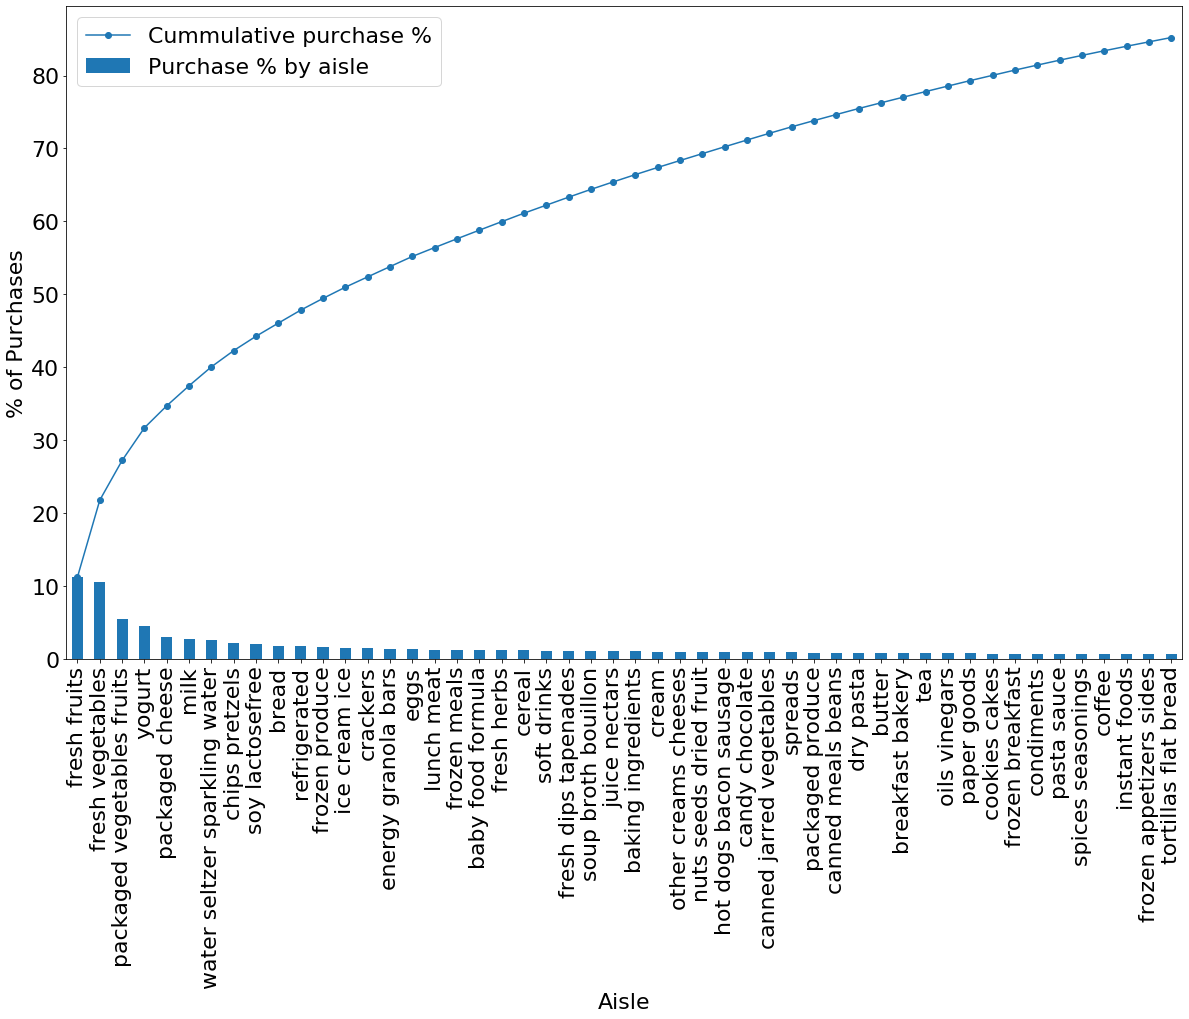

In [12]:
## Visualising results

plt.rcParams["figure.figsize"] = [20, 12]
plt.rcParams.update({'font.size': 22})

ax = aisles_counts_top_n[['aisle', 'cum_purchase_%']].plot(x='aisle', linestyle='-', marker='o', label = 'Cummulative purchase %')
ax = aisles_counts_top_n[['aisle', 'purchase_%']].plot(x='aisle', kind='bar', ax=ax, use_index = True, label = 'Purchase %')
ax.legend(["Cummulative purchase %", "Purchase % by aisle"]);
plt.xlabel('Aisle')
plt.ylabel('% of Purchases')

plt.show()

In [13]:
## How many unique orders does each aisle occur in? - aisle penetration

# Calculating #unique orders for each aisle
aisle_penetration = pd.DataFrame(order_products_prior_df.groupby(['aisle_id', 'aisle']).order_id.nunique()).sort_values(by ='order_id',ascending=False).rename(columns={'order_id':'unique_orders'})

# Calculating aisle penetration
aisle_penetration['aisle_penetration'] = aisle_penetration['unique_orders']*100/order_products_prior_df['order_id'].nunique()

# Formatting
aisle_penetration = aisle_penetration.reset_index()

# Preview
aisle_penetration.head()

,aisle_id,aisle,unique_orders,aisle_penetration
0,24,fresh fruits,1790771,55.702681
1,83,fresh vegetables,1427631,44.407059
2,123,packaged vegetables fruits,1179243,36.680847
3,120,yogurt,847081,26.348809
4,84,milk,785987,24.448454


In [14]:
## Taking top 50 aisles by aisle penetration

aisle_penetration_top_n = pd.DataFrame(aisle_penetration[:50]['aisle_id'])
aisle_penetration_top_n.head()

,aisle_id
0,24
1,83
2,123
3,120
4,84


In [15]:
## How many of the top aisles by purchase % are in top 50 by penetration?

print("Number of aisles that are common in the top 50 by penetration and product purchase counts:", aisles_counts_top_n.merge(aisle_penetration_top_n, how = 'inner').shape[0])

Number of aisles that are common in the top 50 by penetration and product purchase counts: 50


## Customer Segmentation


We will observe customer behavior in these top 50 aisles and use that behavior to reduce the number of dimensions for clustering using PCA.

Clustering in high dimensional spaces becomes difficult since the notion of distance starts changing.

In [16]:
## Creating filtered base data with transactions only for the top n 

order_products_prior_df_top_n_aisles = order_products_prior_df.merge(aisle_penetration_top_n['aisle_id'], on='aisle_id', how = 'inner')
print("Shape of base data:", order_products_prior_df_top_n_aisles.shape)
order_products_prior_df_top_n_aisles.head()

Shape of base data: (27639595, 15)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,22,23341,6,1,Large Grade AA Eggs,86,16,eggs,dairy eggs,30822,prior,25,1,8,12.0
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,eggs,dairy eggs,59897,prior,19,6,10,25.0
3,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs,153404,prior,2,0,16,7.0
4,55,11520,12,0,Large Alfresco Eggs,86,16,eggs,dairy eggs,127522,prior,8,4,14,5.0


In [17]:
# Creating a dataframe with count of all the purchases made by each user - by Aisle

cust_aisle_top_n_aisles = pd.crosstab(order_products_prior_df_top_n_aisles.user_id, order_products_prior_df_top_n_aisles.aisle)
cust_aisle_top_n_aisles.head()

aisle,baby food formula,baking ingredients,bread,breakfast bakery,butter,candy chocolate,canned jarred vegetables,canned meals beans,cereal,chips pretzels,...,refrigerated,soft drinks,soup broth bouillon,soy lactosefree,spices seasonings,spreads,tea,tortillas flat bread,water seltzer sparkling water,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,3,0,...,0,13,0,2,0,1,0,0,0,1
2,0,2,1,1,0,0,0,0,0,12,...,5,0,0,1,0,3,1,0,2,42
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15,0,4,1,0,2,0
4,0,0,1,0,0,0,0,0,0,1,...,1,1,1,0,0,0,0,1,1,0
5,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,3


In [18]:
## List of top 50 aisles

cust_aisle_top_n_aisles.columns.values

array(['baby food formula', 'baking ingredients', 'bread',
       'breakfast bakery', 'butter', 'candy chocolate',
       'canned jarred vegetables', 'canned meals beans', 'cereal',
       'chips pretzels', 'coffee', 'condiments', 'cookies cakes',
       'crackers', 'cream', 'dry pasta', 'eggs', 'energy granola bars',
       'fresh dips tapenades', 'fresh fruits', 'fresh herbs',
       'fresh vegetables', 'frozen appetizers sides', 'frozen breakfast',
       'frozen meals', 'frozen produce', 'hot dogs bacon sausage',
       'ice cream ice', 'instant foods', 'juice nectars', 'lunch meat',
       'milk', 'nuts seeds dried fruit', 'oils vinegars',
       'other creams cheeses', 'packaged cheese', 'packaged produce',
       'packaged vegetables fruits', 'paper goods', 'pasta sauce',
       'refrigerated', 'soft drinks', 'soup broth bouillon',
       'soy lactosefree', 'spices seasonings', 'spreads', 'tea',
       'tortillas flat bread', 'water seltzer sparkling water', 'yogurt'],
      dty

In [19]:
## Running PCA on aisle-counts

from sklearn.decomposition import PCA
pca_top_n = PCA(n_components=2)
pca_top_n.fit(cust_aisle_top_n_aisles)
pca_top_n_samples = pca_top_n.transform(cust_aisle_top_n_aisles)
print("Ratio of variance explained by each PC:",pca_top_n.explained_variance_ratio_)

Ratio of variance explained by each PC: [0.50766929 0.10089249]


In [20]:
## Extracting PC1 and PC2 co-ordinates of each feature

pca_top_n_comp_df = pd.DataFrame(pca_top_n.components_)
pca_top_n_comp_df.columns = cust_aisle_top_n_aisles.columns
pca_top_n_comp_df.head()

aisle,baby food formula,baking ingredients,bread,breakfast bakery,butter,candy chocolate,canned jarred vegetables,canned meals beans,cereal,chips pretzels,...,refrigerated,soft drinks,soup broth bouillon,soy lactosefree,spices seasonings,spreads,tea,tortillas flat bread,water seltzer sparkling water,yogurt
0,0.073034,0.038771,0.076502,0.02905,0.032323,0.030188,0.039441,0.037171,0.039162,0.077051,...,0.067785,0.013161,0.037514,0.085292,0.024972,0.035728,0.028144,0.025047,0.076495,0.225180
1,0.079866,-0.010181,0.052171,0.04979,-0.000019,0.060476,-0.033677,-0.020801,0.068500,0.118619,...,0.104160,0.049265,-0.011026,0.040572,-0.022112,0.032145,0.066967,0.000425,0.159918,0.556152


In [21]:
## Crearting DF to plot these features in the PC space

pca_top_n_comp_df_plt = pca_top_n_comp_df.T.reset_index()
pca_top_n_comp_df_plt.columns = ['aisle_name', 'pc1', 'pc2']

pca_top_n_comp_df_plt['pc1'] = pca_top_n_comp_df_plt['pc1']*100
pca_top_n_comp_df_plt['pc2'] = pca_top_n_comp_df_plt['pc2']*100
pca_top_n_comp_df_plt.head()

,aisle_name,pc1,pc2
0,baby food formula,7.303373,7.986585
1,baking ingredients,3.877081,-1.018113
2,bread,7.650179,5.217099
3,breakfast bakery,2.905048,4.978955
4,butter,3.232279,-0.001926


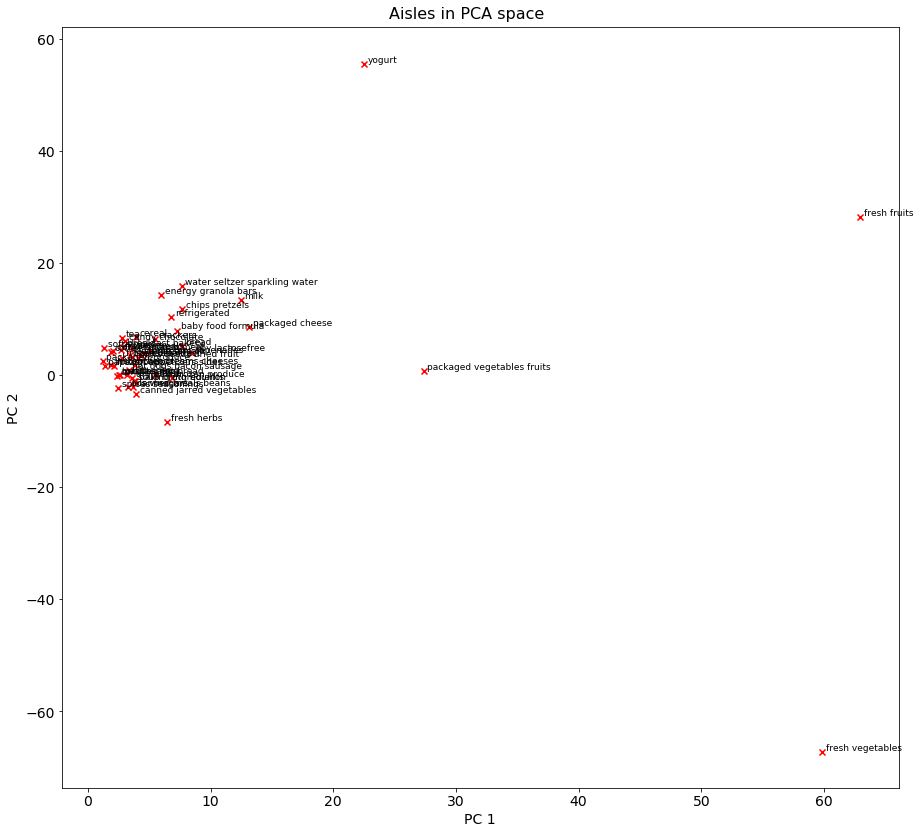

In [22]:
fig = plt.figure(figsize=(15,14))
plt.rcParams.update({'font.size': 14})

for i,pca_name in enumerate(pca_top_n_comp_df_plt['aisle_name']):
    x = pca_top_n_comp_df_plt['pc1'][i]
    y = pca_top_n_comp_df_plt['pc2'][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, pca_name, fontsize=9)
 
plt.suptitle('Aisles in PCA space', y=0.9, size=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### Cleaner plot

As expected, the top 4 aisles behave very differently vs. all other aisles. For a closer look at the other features, we plot without them in the plot.

PC1 seems to capture information related to __________ - actual penetration decreases as we move towards origin along PC1

What does PC2 capture?

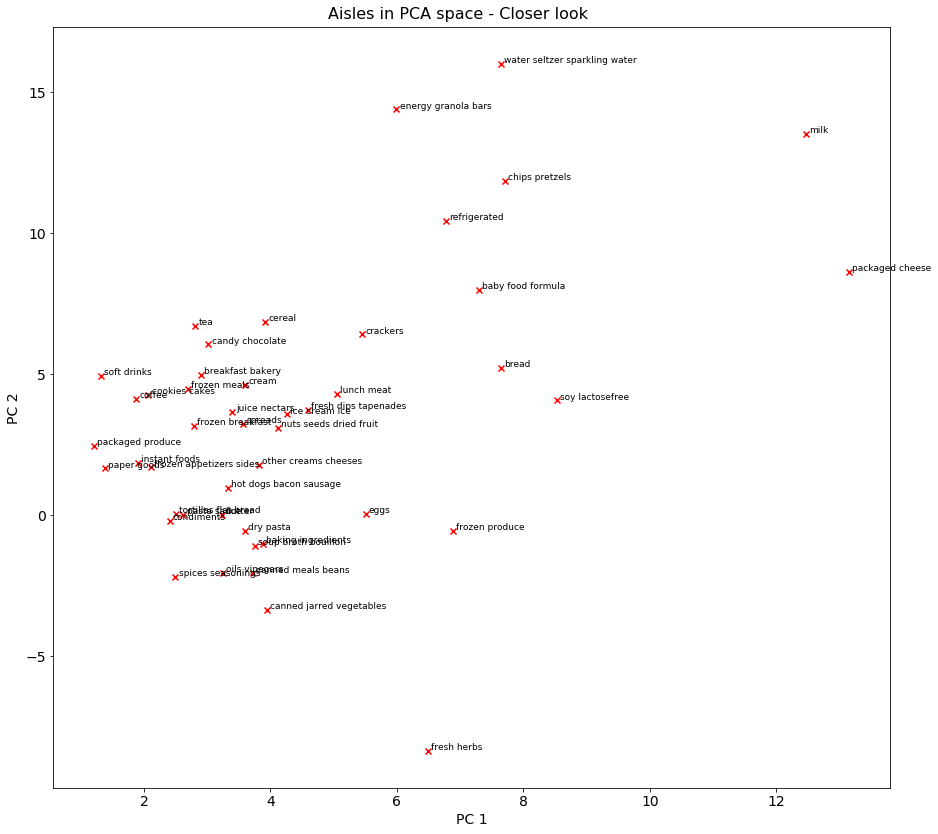

In [23]:
pca_top_n_comp_df_plt_treated = pca_top_n_comp_df_plt[(pca_top_n_comp_df_plt['aisle_name']!='yogurt') & (pca_top_n_comp_df_plt['aisle_name']!='fresh fruits') & (pca_top_n_comp_df_plt['aisle_name']!='fresh vegetables') & (pca_top_n_comp_df_plt['aisle_name']!='packaged vegetables fruits')].reset_index(drop=True)
fig = plt.figure(figsize=(15,14))

for i,pca_name in enumerate(pca_top_n_comp_df_plt_treated['aisle_name']):
    x = pca_top_n_comp_df_plt_treated['pc1'][i]
    y = pca_top_n_comp_df_plt_treated['pc2'][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.05, y+0.05, pca_name, fontsize=9)
 
plt.suptitle('Aisles in PCA space - Closer look', y=0.9, size=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [24]:
## Storing X and Y co-ordinates of data points (users) in PCA space

ps_top_n = pd.DataFrame(pca_top_n_samples)
ps_top_n.head()
tocluster_top_n = pd.DataFrame(ps_top_n)

In [25]:
## Running K-means on all customers who transacted in top n aisles (data points)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(tocluster_top_n)
labels_top_n = kmeans.predict(tocluster_top_n)
centers_top_n = kmeans.cluster_centers_
print(centers_top_n)

[[-16.25027632  -0.22995143]
 [178.14614443  -1.99478063]
 [ 47.99332525   1.64283315]]


In [26]:
## adding cluster information for all users

ps_top_n['cluster']=labels_top_n
ps_top_n['user_id'] = cust_aisle_top_n_aisles.index
ps_top_n = ps_top_n[['user_id',0,1,'cluster']]
ps_top_n.columns = ['user_id','PC1','PC2','cluster']
ps_top_n.head()

,user_id,PC1,PC2,cluster
0,1,-24.266824,2.116680,0
1,2,6.320396,36.726611,0
2,3,-7.836645,2.506221,0
3,4,-27.882349,-0.717800,0
4,5,-19.803518,-2.551739,0


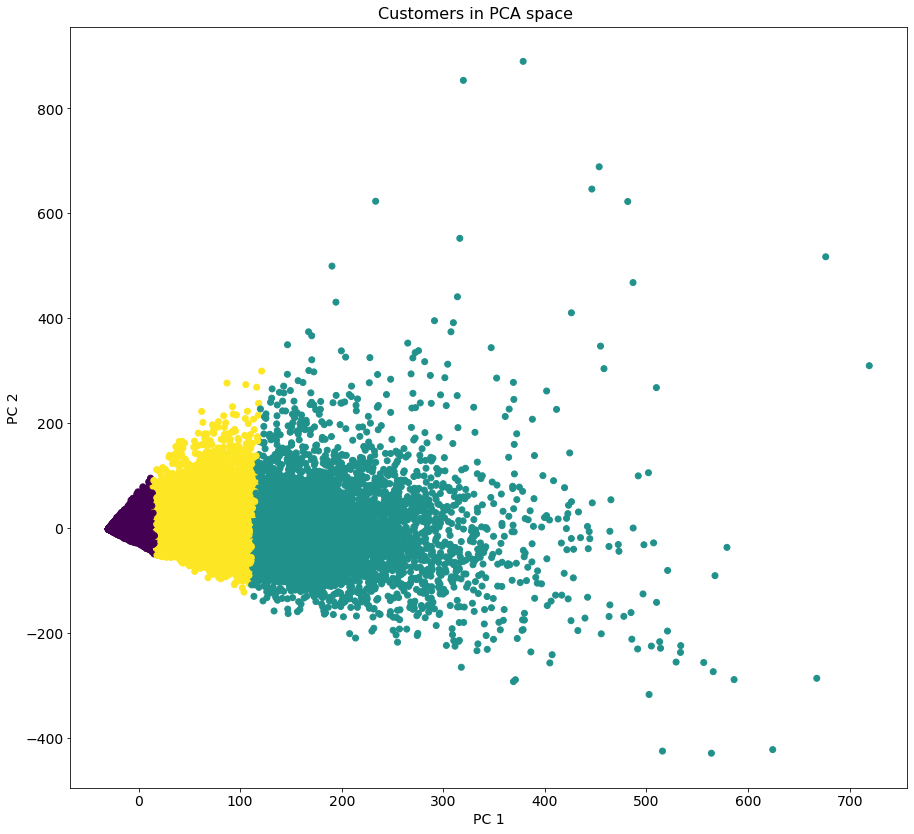

In [27]:
## Plotting all users colored by clusters

fig = plt.figure(figsize=(15,14))

plt.scatter(ps_top_n['PC1'],ps_top_n['PC2'], marker='o', c=ps_top_n['cluster'])

plt.suptitle('Customers in PCA space', y=0.9, size=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

## Creating user level metrics

In [28]:
## Calculating average order gap for each user

user_days_prior = pd.DataFrame(order_products_prior_df[['user_id','order_id','days_since_prior_order']].drop_duplicates())
user_days_prior = pd.DataFrame(user_days_prior.groupby('user_id')['days_since_prior_order'].mean()).reset_index()
user_days_prior.columns = ['user_id','avg_order_gap']
user_days_prior.head()

,user_id,avg_order_gap
0,1,19.555556
1,2,15.230769
2,3,12.090909
3,4,13.750000
4,5,13.333333


In [29]:
order_products_prior_df_top_n_aisles.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,22,23341,6,1,Large Grade AA Eggs,86,16,eggs,dairy eggs,30822,prior,25,1,8,12.0
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,eggs,dairy eggs,59897,prior,19,6,10,25.0
3,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs,153404,prior,2,0,16,7.0
4,55,11520,12,0,Large Alfresco Eggs,86,16,eggs,dairy eggs,127522,prior,8,4,14,5.0


In [30]:
## Combining user level info

## Order and purchase information
user_info = pd.DataFrame(order_products_prior_df_top_n_aisles.groupby('user_id')['order_id'].agg(['count','nunique'])).reset_index()
user_info.columns = ['user_id','purchase_count','order_count']

## Average order gap
user_info = user_info.merge(user_days_prior, on = 'user_id', how = 'inner')

## Average basket size
user_info['avg_basket_size'] = user_info['purchase_count']/user_info['order_count']

## Cluster information
user_info = user_info.merge(ps_top_n[['user_id','cluster']], on = 'user_id', how = 'inner')


user_info.head()

,user_id,purchase_count,order_count,avg_order_gap,avg_basket_size,cluster
0,1,47,10,19.555556,4.700000,0
1,2,168,14,15.230769,12.000000,0
2,3,86,12,12.090909,7.166667,0
3,4,14,4,13.750000,3.500000,0
4,5,33,4,13.333333,8.250000,0


## Should we split 1 & done customers?

In [31]:
user_info[user_info['order_count']==1].count()*100/user_info[user_info['cluster']==0].count()

user_id            0.288933
purchase_count     0.288933
order_count        0.288933
avg_order_gap      0.288933
avg_basket_size    0.288933
cluster            0.288933
dtype: float64

We see that these customers are 0.28% of our low transacting customers, which is negligible. We will __not consider them as a separate cluster.__ 

Instead, we will add a one_n_done flag.

### Adding one_n_done flag

In [32]:
user_info['one_n_done'] = np.where(user_info['order_count']==1, 1, 0)

# Cluster level metrics

### Excluding one_n_done

In [33]:
## Overall segments

cluster_info = user_info.groupby('cluster')['avg_basket_size','order_count','purchase_count','avg_order_gap'].agg({'avg_order_gap':['mean','median'],'avg_basket_size':['mean','median','count'],'purchase_count':['sum'],'order_count':['mean','median','sum']})
cluster_info.columns = cluster_info.columns.map('_'.join)
cluster_info['perc_cust_in_clust'] = cluster_info['avg_basket_size_count']*100/cluster_info['avg_basket_size_count'].sum(axis = 0)
cluster_info['perc_order_from_clust'] = cluster_info['order_count_sum']*100/cluster_info['order_count_sum'].sum(axis = 0)
cluster_info['perc_purch_from_clust'] = cluster_info['purchase_count_sum']*100/cluster_info['purchase_count_sum'].sum(axis = 0)
cluster_info = cluster_info.reset_index()
cluster_info.head()

,cluster,avg_order_gap_mean,avg_order_gap_median,avg_basket_size_mean,avg_basket_size_median,avg_basket_size_count,purchase_count_sum,order_count_mean,order_count_median,order_count_sum,perc_cust_in_clust,perc_order_from_clust,perc_purch_from_clust
0,0,16.513949,16.200000,7.664169,6.800000,167513,11902669,10.208175,7,1710002,81.328045,54.107429,43.063833
1,1,6.277394,6.051724,14.060886,13.068966,6771,5291989,60.706986,56,411047,3.287340,13.006240,19.146406
2,2,10.192695,9.500000,11.619783,10.720000,31688,10444937,32.798978,29,1039334,15.384615,32.886331,37.789761


## Cluster level metric list:

1. avg order gap (mean) - in days
2. avg order gap (median) - in days
3. avg basket size (mean) - number of unique items/basket on an average (signals variety rather than actual basket size)
4. avg basket size (median) - number of unique items/basket on an average (signals variety rather than actual basket size)
5. avg basket size (count) - number of rows ==> proxy for number of users in cluster
6. purchase count (sum) - total number of items purchased by customers in cluster
7. order count (mean)- average number of orders for customers of cluster
8. order count (median)- median number of orders for customers of cluster
9. order count (sum)- total number of orders for customers of cluster
10. perc cust in clust - total percentage of customers in cluster
11. perc order from clust - total percentage of orders from cluster
12. perc purch from clust - total percentage of purchases from cluster

### Including one_n_done

In [34]:
## Overall segments

cluster_info_one_n_done = user_info.groupby(['cluster','one_n_done'])['avg_basket_size','order_count','purchase_count'].agg({'avg_basket_size':['mean','median','count'],'purchase_count':['mean','median','sum'],'order_count':['mean','median','sum']})
cluster_info_one_n_done.columns = cluster_info_one_n_done.columns.map('_'.join)
cluster_info_one_n_done['perc_cust_in_clust'] = cluster_info_one_n_done['avg_basket_size_count']*100/cluster_info_one_n_done['avg_basket_size_count'].sum(axis = 0)
cluster_info_one_n_done['perc_order_from_clust'] = cluster_info_one_n_done['order_count_sum']*100/cluster_info_one_n_done['order_count_sum'].sum(axis = 0)
cluster_info_one_n_done['perc_purch_from_clust'] = cluster_info_one_n_done['purchase_count_sum']*100/cluster_info_one_n_done['purchase_count_sum'].sum(axis = 0)
cluster_info_one_n_done = cluster_info_one_n_done.reset_index()
cluster_info_one_n_done.head()

,cluster,one_n_done,avg_basket_size_mean,avg_basket_size_median,avg_basket_size_count,purchase_count_mean,purchase_count_median,purchase_count_sum,order_count_mean,order_count_median,order_count_sum,perc_cust_in_clust,perc_order_from_clust,perc_purch_from_clust
0,0,0,7.678936,6.818182,167029,71.253651,53,11901426,10.234857,7,1709518,81.093061,54.092115,43.059336
1,0,1,2.568182,2.000000,484,2.568182,2,1243,1.000000,1,484,0.234983,0.015315,0.004497
2,1,0,14.060886,13.068966,6771,781.566829,728,5291989,60.706986,56,411047,3.287340,13.006240,19.146406
3,2,0,11.619783,10.720000,31688,329.618057,299,10444937,32.798978,29,1039334,15.384615,32.886331,37.789761


## Aisle penetrations

In [35]:
order_products_prior_df = order_products_prior_df.merge(user_info[['user_id','cluster']], on = 'user_id', how = 'inner')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,0


In [36]:
## How many unique orders does each aisle occur in? - aisle penetration

# Calculating #unique orders for each aisle
aisle_penetration_orders = pd.DataFrame(order_products_prior_df.groupby(['cluster','aisle_id', 'aisle']).order_id.nunique()).sort_values(by ='order_id',ascending=False).rename(columns={'order_id':'unique_orders'})

# Calculating aisle penetration
aisle_penetration_orders['aisle_penetration'] = aisle_penetration_orders['unique_orders']*100/order_products_prior_df['order_id'].nunique()

# Formatting
aisle_penetration_orders = aisle_penetration_orders.reset_index()

# Preview
aisle_penetration_orders.head()

,cluster,aisle_id,aisle,unique_orders,aisle_penetration
0,0,24,fresh fruits,745092,23.185586
1,2,24,fresh fruits,712648,22.176002
2,2,83,fresh vegetables,572943,17.828697
3,0,83,fresh vegetables,569855,17.732605
4,0,123,packaged vegetables fruits,488147,15.190036


In [37]:
## How many unique orders does each aisle occur in? - aisle penetration

# Calculating #unique orders for each aisle
aisle_penetration_purc = pd.DataFrame(order_products_prior_df.groupby(['cluster','aisle_id', 'aisle']).order_id.count()).sort_values(by ='order_id',ascending=False).rename(columns={'order_id':'unique_purch'})

# Calculating aisle penetration
aisle_penetration_purc['aisle_penetration'] = aisle_penetration_purc['unique_purch']*100/order_products_prior_df['order_id'].count()

# Formatting
aisle_penetration_purc = aisle_penetration_purc.reset_index()

# Preview
aisle_penetration_purc.head()

,cluster,aisle_id,aisle,unique_purch,aisle_penetration
0,2,24,fresh fruits,1490944,4.597143
1,2,83,fresh vegetables,1403031,4.326074
2,0,24,fresh fruits,1264636,3.899350
3,0,83,fresh vegetables,1174830,3.622444
4,1,24,fresh fruits,886608,2.733747


In [38]:
## ATC penetration

## How many unique orders does each aisle occur in? - aisle penetration by atc-order

# Calculating #unique orders for each aisle
aisle_penetration_atc = pd.DataFrame(order_products_prior_df.groupby(['cluster','aisle_id', 'aisle','add_to_cart_order']).order_id.count()).sort_values(by ='order_id',ascending=False).rename(columns={'order_id':'unique_orders'})

# Calculating aisle penetration
aisle_penetration_atc['aisle_penetration'] = aisle_penetration_atc['unique_orders']*100/order_products_prior_df['order_id'].nunique()

# Formatting
aisle_penetration_atc = aisle_penetration_atc.reset_index()

# Preview
aisle_penetration_atc.head()

,cluster,aisle_id,aisle,add_to_cart_order,unique_orders,aisle_penetration
0,0,24,fresh fruits,1,186396,5.800224
1,2,24,fresh fruits,1,176342,5.487366
2,0,24,fresh fruits,2,174456,5.428678
3,2,24,fresh fruits,2,171070,5.323313
4,2,24,fresh fruits,3,154487,4.807288


## Lift Calculator - Return pairs of products/aisles with high lift

In [39]:
import mlxtend
from mlxtend.preprocessing import TransactionEncoder

def one_hot_encoder(df, antecendent_list, ideal_cluster):
    
    ## df: dataframe to be used
    ## id_col: which column to use for unique identifiers of frequent items (aisle, product)
    ## name_col: which column to use for names of frequent_items
    ## antecedent list: list of objects to be used as antecedents
    
    trans_df = df
    
    ## Filtering transactions only for target cluster and ideal cluster
    trans_df = trans_df[(trans_df['cluster']== ideal_cluster)]
    
    ## Selecting transactions with antecedent aisles present
    order_list_base = trans_df[(trans_df['aisle_id'].isin(antecendent_list))]
    order_list = pd.DataFrame(order_list_base['order_id'].unique())
    order_list.columns=['order_id']
    
    ## Filtered transactions for antecedent list
    trans_df_filtered = trans_df.merge(order_list, on='order_id', how='inner')
    
    orders = order_list['order_id'].tolist()
    transaction_aisles = []
    
    for order in orders:
        tmp_df = trans_df_filtered[trans_df_filtered['order_id']==order]
        aisles_tmp = tmp_df['aisle'].unique().tolist()
        transaction_aisles.append(aisles_tmp)
    
    te = TransactionEncoder()
    te_ary = te.fit(transaction_aisles).transform(transaction_aisles)
    trans_onehot = pd.DataFrame(te_ary, columns=te.columns_)
    
    return trans_onehot

In [50]:
import mlxtend
from mlxtend.preprocessing import TransactionEncoder

def one_hot_encoder_overall(df, ideal_cluster):
    
    ## df: dataframe to be used
    ## id_col: which column to use for unique identifiers of frequent items (aisle, product)
    ## name_col: which column to use for names of frequent_items
    ## antecedent list: list of objects to be used as antecedents
    
    trans_df = df
    
    ## Filtering transactions only for target cluster and ideal cluster
    trans_df = trans_df[(trans_df['cluster']== ideal_cluster)]
   
    orders = trans_df['order_id'].tolist()
    transaction_aisles = []
    
    for order in orders:
        tmp_df = trans_df[trans_df['order_id']==order]
        aisles_tmp = tmp_df['aisle'].unique().tolist()
        transaction_aisles.append(aisles_tmp)
    
    te = TransactionEncoder()
    te_ary = te.fit(transaction_aisles).transform(transaction_aisles)
    trans_onehot = pd.DataFrame(te_ary, columns=te.columns_)
    
    return trans_onehot

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Cluster 1

In [ ]:
## Transforming transactions to 1-hot

encoded_transactions_cluster_1 = one_hot_encoder_overall(order_products_prior_df,1)

In [61]:
## Calculating inter-aisle, aisle level lifts

frequent_itemsets_aisle_cluster_1 = apriori(encoded_transactions_cluster_1, min_support=0.2, use_colnames=True)
aisle_association_rules_df_cluster_1 = association_rules(frequent_itemsets_aisle_cluster_1, metric="lift", min_threshold=1)

In [ ]:
aisle_association_rules_df_cluster_1.to_csv('aisle_association_rules_df_cluster_1.csv')

## Cluster 2

In [ ]:
## Transforming transactions to 1-hot

encoded_transactions_cluster_2 = one_hot_encoder_overall(order_products_prior_df,2)

In [61]:
## Calculating inter-aisle, aisle level lifts

frequent_itemsets_aisle_cluster_2 = apriori(encoded_transactions_cluster_2, min_support=0.2, use_colnames=True)
aisle_association_rules_df_cluster_2 = association_rules(frequent_itemsets_aisle_cluster_2, metric="lift", min_threshold=1)

In [ ]:
aisle_association_rules_df_cluster_2.to_csv('aisle_association_rules_df_cluster_2.csv')

## Cluster 0

In [ ]:
# ## Transforming transactions to 1-hot

# encoded_transactions_cluster_0 = one_hot_encoder_overall(order_products_prior_df,0)

In [61]:
# ## Calculating inter-aisle, aisle level lifts

# from mlxtend.frequent_patterns import apriori
# from mlxtend.frequent_patterns import association_rules


# frequent_itemsets_aisle_cluster_0 = apriori(encoded_transactions_cluster_0, min_support=0.2, use_colnames=True)
# aisle_association_rules_df_cluster_0 = association_rules(frequent_itemsets_aisle_cluster_0, metric="lift", min_threshold=1)

In [ ]:
# aisle_association_rules_df_cluster_0.to_csv('aisle_association_rules_df_cluster_0.csv')

# Appendix

In [ ]:
## Downloading cluster info

#cluster_info.to_csv('cluster_info.csv')